In [2]:
# IMPORT MODULES
import pandas as pd
import os
import glob
import csv

In [3]:
# IMPORT FILE PATHS 
active_project = "../reports/current/"
csv_output = "../export/"

csv_files = glob.glob(os.path.join(active_project, "*.csv"))

In [4]:
# setting up the list for all raw dfs
all_df = []

# listing turning movement counts as current 
current_TMC_list = []

for l in csv_files:
    current_TMC_list.append(l)

In [18]:
# function to read all csvs listed 

def read_csv(file_path):
    try:
        imp_df = pd.read_csv(file_path, 
                             sep='delimiter',
                             header=None,
                             engine='python'
                            )
        return imp_df #imp_df as in imported dataframe
    except pd.errors.ParserError as e:
        return (file_path, f"Error parsing CSV: {str(e)}")  # Return tuple with file path and error message
    except FileNotFoundError:
        return (file_path, "File not found")  # Return tuple with file path and error message


In [19]:
## validating dataframes

for file_path in current_TMC_list:
    imp_df = read_csv(file_path)  # Assign the returned DataFrame to imp_df
    all_df.append(imp_df)  # Append imp_df to all_df

valid_dfs = [df for df in all_df if isinstance(df, pd.DataFrame)]  # Filter out non-DataFrame objects

In [20]:
print(len(valid_dfs))

529


In [116]:
## modify each dataframe in two parts

def modify_in_df(df):
    # Part A: Summary
    summary_end_row = df.index[df.iloc[:, 0].notna() & df.iloc[:, 0].str.startswith("PM Peak")].tolist()[0]
    summary = df.iloc[:summary_end_row + 1, :]
    summary = summary.iloc[1:]  # Remove the first row
    summary = summary[~summary.eq("").all(axis=1)] # drop rows with empty strings
    summary = summary.dropna(how='all') #another attempt to drop empty
    summary.reset_index(drop=True, inplace=True)
    summary = summary.drop(10)
    summary = summary.rename(columns={summary.columns[0]: "Summary Description"})  # Rename the second column
    summary.reset_index(drop=True, inplace=True)

    ## Convert all values in the "Summary Description" column to strings
    summary["Summary Description"] = summary["Summary Description"].astype(str)

    ## Define a regular expression pattern to extract the desired substrings
    pattern = r'(.*?),(.*)'

    ## Extract the substrings using the pattern
    summary = summary["Summary Description"].str.extract(pattern)

    ## Formatting
    summary = summary.rename(columns={summary.columns[0]: "Summary Description"})  # Rename the first column
    summary = summary.rename(columns={summary.columns[1]: "Summary"})  # Rename the first column

    # Flip rows to columns
    transposed_summary = summary.transpose().reset_index(drop=True)
    new_header = transposed_summary.iloc[0]  # Store the first row as the new header
    transposed_summary.columns = new_header  # Set the new header
    transposed_summary_clean = transposed_summary[transposed_summary.index != "Summary"]
    transposed_summary_clean = transposed_summary.iloc[1:]
    transposed_summary_clean = transposed_summary_clean.dropna(axis='columns')

    # Separate out key infomration
    transposed_summary_clean[['Location A','Location B']] = transposed_summary_clean['Location'].str.split(' at ', n=1, expand=True)
    transposed_summary_clean[['Longitude', 'Latitude']] = transposed_summary_clean['Latitude and Longitude'].str.split(',', expand=True)
    transposed_summary_clean[['Longitude', 'Latitude']] = transposed_summary_clean['Latitude and Longitude'].str.replace('"', '').str.split(',', expand=True)
    transposed_summary_clean[['Year', 'Quarter']] = pd.to_datetime(transposed_summary_clean['End Time']).dt.to_period('Q').astype(str).str.split("Q", expand=True)

    # Prepare information for raw merging

    summmary_dim = transposed_summary_clean.drop(['Legs and Movements',
                                              'Bin Size',
                                              'Time Zone',
                                              'Start Time',
                                              'End Time',
                                              'Location',
                                              'Latitude and Longitude'],axis=1)

    # Part B: Raw Data 
    raw_data_startrow = df.index[df.iloc[:, 0] == "Time,Entry,Entry Direction,Exit,Exit Direction,Movement,Class,Volume"].tolist()[0]
    raw_data = df.iloc[raw_data_startrow:, :]  # Extract from the starting row onwards
    raw_data.reset_index(drop=True, inplace=True)
    raw_data = raw_data.rename(columns={raw_data.columns[0]:"rawdata"})
    raw_table = raw_data["rawdata"].str.split(',',expand=True) #split columns
    raw_header = raw_table.iloc[0]
    raw_table.columns = raw_header  # Set the new header
    raw_table = raw_table.iloc[1:]  # Remove the first row

    # Merge the row of 'summary_dim' to each row in 'raw data
    merged_data = pd.merge(raw_table, summmary_dim, how='cross')
    
    return merged_data

In [ ]:
## loop through dataframes

modified_df_list = []  # List to store the modified DataFrames
error_log = []  # List to store the error details
df = pd.DataFrame()

for i in range(len(valid_dfs)):
    try:
        df = valid_dfs[i]  # Retrieve the DataFrame by index
        modified_df = modify_in_df(df)  # Modify the DataFrame
        modified_df_list.append(modified_df)  # Append the modified DataFrame to the list
    except Exception as e:
        error_log.append((i, str(e)))  # Log the index and error message


In [124]:
big_df = pd.concat(modified_df_list, ignore_index=True)


,Time,Entry,Entry Direction,Exit,Exit Direction,Movement,Class,Volume,Study Name,Project,...,Year,Quarter,AM Peak (WKND),Midday Peak (WKND) (Overall Peak Hour),PM Peak (WKND),AM Peak (Overall Peak Hour),PM Peak,Midday Peak (WKND),PM Peak (WKND) (Overall Peak Hour),Midday Peak (Overall Peak Hour)
0,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,West,Right,Lights,2,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,West,Right,Articulated Trucks,0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,West,Right,Buses and Single-Unit Trucks,0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,West,Right,Bicycles on Road,0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,Barker Cypress Dr,South,Thru,Lights,697,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,Barker Cypress Dr,South,Thru,Articulated Trucks,0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,Barker Cypress Dr,South,Thru,Buses and Single-Unit Trucks,9,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,Barker Cypress Dr,South,Thru,Bicycles on Road,0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,East,Left,Lights,7,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,East,Left,Articulated Trucks,0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
big_df.describe()

,Time,Entry,Entry Direction,Exit,Exit Direction,Movement,Class,Volume,Study Name,Project,...,Year,Quarter,AM Peak (WKND),Midday Peak (WKND) (Overall Peak Hour),PM Peak (WKND),AM Peak (Overall Peak Hour),PM Peak,Midday Peak (WKND),PM Peak (WKND) (Overall Peak Hour),Midday Peak (Overall Peak Hour)
count,347399,347399,347399,347399,347399,347399,347399,347399,347399,347399,...,347399,347399,4258,1339,1339,51642,54424,2919,2919,2782
unique,2101,908,4,909,5,6,6,1325,491,5,...,4,4,8,2,2,67,76,6,6,5
top,2022-09-07 08:00:00 -0500,Kuykendahl Rd,North,"""""","""""",U-Turn,Lights,0,89 - Peek Rd at Elyson Falls Dr,Harris County - Open PO 2020,...,2022,4,9:15 AM - 10:15 AM (0.913),11:45 AM - 12:45 PM (0.864),2 PM - 3 PM (0.935),6:45 AM - 7:45 AM (0.783),3:30 PM - 4:30 PM (0.742),12 PM - 1 PM (0.964),5:30 PM - 6:30 PM (0.953),12 PM - 1 PM (0.906)
freq,913,3172,87524,90470,90470,69549,84824,251074,1536,83239,...,200538,99309,832,832,832,2496,1536,832,832,832


In [131]:
big_df['Volume'] = big_df['Volume'].astype(float)

In [132]:
big_df.head(2)

,Time,Entry,Entry Direction,Exit,Exit Direction,Movement,Class,Volume,Study Name,Project,...,Year,Quarter,AM Peak (WKND),Midday Peak (WKND) (Overall Peak Hour),PM Peak (WKND),AM Peak (Overall Peak Hour),PM Peak,Midday Peak (WKND),PM Peak (WKND) (Overall Peak Hour),Midday Peak (Overall Peak Hour)
0,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,West,Right,Lights,2.0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07-07 06:00:00 -0500,Barker Cypress Dr,North,River Sage Rd,West,Right,Articulated Trucks,0.0,11 - Barker Cypress Rd at River Sage Dr,Harris County - Open PO 2020,...,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
big_df.to_csv(os.path.join(csv_output, 'combined_02.csv'), index=False)

# Analysis 

In [135]:
grp_byproj = big_df.groupby(['Project']).agg({
    'Volume' : 'sum',
    'Year': 'first',
    'Quarter': 'first',
    'Longitude': 'first',
    'Latitude': 'first'
}).reset_index()

In [136]:
grp_byproj

,Project,Volume,Year,Quarter,Longitude,Latitude
0,2-1058 - Harris County - Open PO#36384,956294.0,2021,3,29.997896,-95.797362
1,2-4686 - Harris County - PO 2022-45695,1049938.0,2022,2,30.103385,-95.499133
2,2-6404 - Harris County - PO-May 2022 Pt 2,1156824.0,2022,2,30.11023,-95.512759
3,2-7900 - Harris Co. Oct. Open PO,1222130.0,2022,4,29.941478,-95.762904
4,Harris County - Open PO 2020,766079.0,2020,3,29.853378,-95.683233


In [137]:
grp_bystudy = big_df.groupby(['Study Name']).agg({
    'Volume' : 'sum',
    'Year': 'first',
    'Quarter': 'first',
    'Longitude': 'first',
    'Latitude': 'first'
}).reset_index()

In [138]:
grp_bystudy

,Study Name,Volume,Year,Quarter,Longitude,Latitude
0,.37 - Louetta Rd at Path 1 - Weekday,9571.0,2022,4,29.99882,-95.649234
1,1 - Atascocita Rd at Grand Prix Drive,14649.0,2022,1,29.96108,-95.255317
2,1 - Creekview Dr at Inway Dr,1277.0,2022,2,30.11023,-95.512759
3,1 - Laura Beth Dr at Burns Lake Dr,440.0,2021,3,29.997896,-95.797362
4,1 - TC Jester Blvd at Ashmere Ln,10535.0,2022,4,30.025853,-95.499501
...,...,...,...,...,...,...
486,98 - W Lake Houston Pkwy at Hunters Lake Way/C...,34407.0,2022,2,29.924329,-95.190074
487,99 - Capstone Dr at Donellan Dr,748.0,2022,2,29.892265,-95.45635
488,99 - Eldridge Pkwy at Ortega Lane,12788.0,2021,2,29.693318,-95.622944
489,99 - Kuykendahl Rd at Alvin A Klein Dr,24528.0,2022,2,30.069363,-95.508425


In [139]:
big_df.to_csv(os.path.join(csv_output, 'Miovision_TMC_Current_RAW.csv'), index=False)
grp_byproj.to_csv(os.path.join(csv_output, 'Miovision_TMC_Current_prj.csv'), index=False)
grp_bystudy.to_csv(os.path.join(csv_output, 'Miovision_TMC_Current_sty.csv'), index=False)

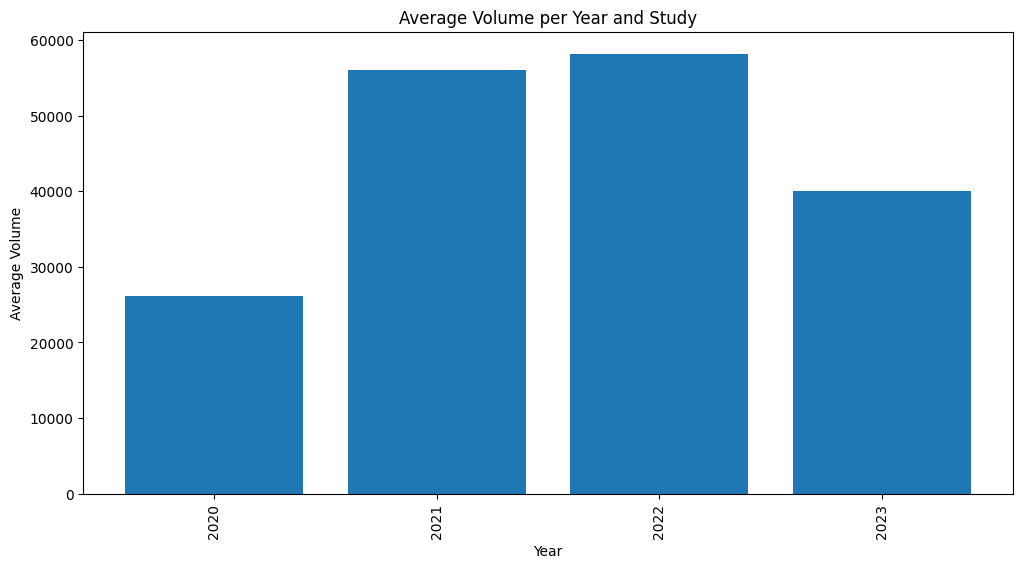

In [150]:
import matplotlib.pyplot as plt

# Group the data by Year and Quarter and calculate count and average volume
yearchart = big_df.groupby(['Year','Study Name']).agg({'Volume': 'sum'}).reset_index()

# Create the chart
plt.figure(figsize=(12, 6))
plt.bar(yearchart['Year'], yearchart['Volume'])
plt.xlabel('Year')
plt.ylabel('Average Volume')
plt.title('Average Volume per Year and Study')
plt.xticks(rotation=90)
plt.show()